<h1>A survey of the translational machinery across the fungal kingdom</h1>

<h2>1. Data sources</h2>

<p>Data for this project came from
    <ul>
        <li>The <a href="http://fungi.ensembl.org" target="blank">fungal division of ENSEMBL</a></li>
        <li>The JGI's <a href="https://genome.jgi.doe.gov/programs/fungi/" target="blank">MycoCosm portal</a>.</li>
        <li>The NCBI's <a href="https://www.ncbi.nlm.nih.gov/genome/" target="blank">Genome Section</a>.</li>
    </ul>
</p>

In [1]:
import requests
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
#from matplotlib_venn import venn3

<h3>Fungal Genomes in ENSEMBL</h3>

In [3]:
#Download the species list from ensembl
ensembl_url = 'http://fungi.ensembl.org/species.html'
ensembl_r = requests.get(ensembl_url)

In [4]:
#extract the species table from the html data
ensembl_soup = BeautifulSoup(ensembl_r.text,'lxml')
ensembl_html = ensembl_soup.find('table')
ensembl_table = pd.read_html(str(ensembl_html))
#only keep columns with relevant information
ensembl_table = ensembl_table[0][['Name','Taxon ID','Assembly','Accession']]
#recover species names from the "name" column (remove strain names)
tvar = ensembl_table['Name'].str.split(' ')
ensembl_table['Species'] = tvar.str.get(0) + ' ' + tvar.str.get(1)
#reorder columns
ensembl_table = ensembl_table[['Species','Name','Taxon ID','Assembly','Accession']]
ensembl_unique_species = pd.unique(ensembl_table.Species)

<h3>Fungal Genomes at the JGI</h3>


In [5]:
#download the species lisy from JGI
jgi_url = 'https://genome.jgi.doe.gov/fungi/fungi.info.html'
jgi_r = requests.get(jgi_url)

In [6]:
#extract the species table from the html data
jgi_soup = BeautifulSoup(jgi_r.text,'lxml')
jgi_html = jgi_soup.find('table')
jgi_table = pd.read_html(str(jgi_html))
jgi_table = jgi_table[0][1]
#recover species names (remove strain names)
tvar = jgi_table.str.split(' ')
jgi_species = tvar.str.get(0) + ' ' + tvar.str.get(1)
jgi_unique_species = pd.unique(jgi_species)

<h3>Fungal Genomes at the NCBI</h3>

In [19]:
#file downloaded from 'ftp://ftp.ncbi.nlm.nih.gov/genomes/GENOME_REPORTS/eukaryotes.txt' on 11/02/2018 
#and filtered for fungal species
ncbi_table = pd.read_csv('180211ncbi.csv')
#recover species names (remove strain names)
tvar = ncbi_table['#Organism/Name'].str.split(' ')
ncbi_species = tvar.str.get(0) + ' ' + tvar.str.get(1)
ncbi_table['Species'] = ncbi_species
ncbi_unique_species = pd.unique(ncbi_species)

<h3>Dataset overlap</h3>

In [24]:
all_species = np.concatenate([ensembl_unique_species, jgi_unique_species,ncbi_unique_species])
all_unique_species = np.unique(all_species)
print('Found genomes for ' + str(all_unique_species.shape[0]) + ' species.')


Found genomes for 1695 species.


In [15]:
ensembl, jgi, ncbi = [],[],[]
for species in all_unique_species:
    if species in jgi_unique_species and species in ensembl_unique_species and species in ncbi_unique_species:
        ensembl.append(1); jgi.append(1); ncbi.append(1)
    elif species in jgi_unique_species and species in ensembl_unique_species:
        ensembl.append(1); jgi.append(1); ncbi.append(0)
    elif species in jgi_unique_species and species in ncbi_unique_species: 
        ensembl.append(0); jgi.append(1); ncbi.append(1)
    elif species in ensembl_unique_species and species in ncbi_unique_species: 
        ensembl.append(1); jgi.append(0); ncbi.append(1)
    elif species in ensembl_unique_species:
        ensembl.append(1); jgi.append(0); ncbi.append(0)
    elif species in jgi_unique_species:
        ensembl.append(0); jgi.append(1); ncbi.append(0)
    elif species in ncbi_unique_species:
        ensembl.append(0); jgi.append(0); ncbi.append(1)
    else:
        ensembl.append(0); jgi.append(0); ncbi.append(0)

species_master = pd.DataFrame(
    {'Species': all_unique_species,
     'ENSEMBL': ensembl,
     'JGI': jgi,
     'NCBI': ncbi
    })
species_master = species_master[['Species','ENSEMBL','JGI','NCBI']]

In [75]:
#determine the highest status entry for ncbi genomes with multiple associated genome projects
Highest_Status = []
for entry in range(species_master.shape[0]):
    this_genome_set = ncbi_table[ncbi_table['Species'] == species_master.Species[entry]]
    if this_genome_set.shape[0] > 0:
        if 'Complete Genome' in this_genome_set['Status'].values:
            Highest_Status.append('Complete Genome')
        elif 'Chromosome' in this_genome_set['Status'].values:
            Highest_Status.append('Chromosome')
        elif 'Scaffold' in this_genome_set['Status'].values:
            Highest_Status.append('Scaffold')
        elif 'Contig' in this_genome_set['Status'].values:
            Highest_Status.append('Contig')
        else:
            Highest_Status.append('')
    else:
        Highest_Status.append('')
species_master['Highest_Status'] = Highest_Status

In [165]:
#split species master into subsets depending on whether ncbi is the only database or not
ncbi_only = pd.DataFrame()
ncbi_ENSEMBL = pd.DataFrame()
ncbi_JGI = pd.DataFrame()
temp = species_master[species_master['NCBI'] == 1]
for row in range(temp.shape[0]):
    this_row = pd.DataFrame(temp.iloc[row,:]).transpose()
    if int(this_row.ENSEMBL) == 1:
        ncbi_ENSEMBL = pd.concat([ncbi_ENSEMBL, this_row])
    elif int(this_row.JGI) == 1:
        ncbi_JGI = pd.concat([ncbi_JGI, this_row])
    else:
        ncbi_only = pd.concat([ncbi_only, this_row])

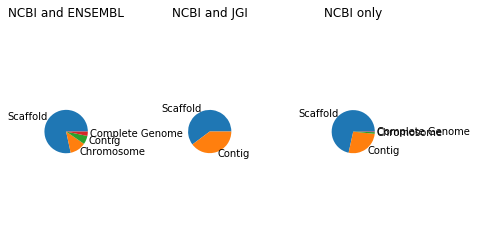

In [166]:
#ransform data for constructing pie charts in pyplot
ncbi_only_count = ncbi_only['Highest_Status'].value_counts()
ncbi_only_count = dict(ncbi_only_count)
ncbi_only_labels = ncbi_only_count.keys()
ncbi_only_sizes = ncbi_only_count.values()

ncbi_ENSEMBL_count = ncbi_ENSEMBL['Highest_Status'].value_counts()
ncbi_ENSEMBL_count = dict(ncbi_ENSEMBL_count)
ncbi_ENSEMBL_labels = ncbi_ENSEMBL_count.keys()
ncbi_ENSEMBL_sizes = ncbi_ENSEMBL_count.values()

ncbi_JGI_count = ncbi_JGI['Highest_Status'].value_counts()
ncbi_JGI_count = dict(ncbi_JGI_count)
ncbi_JGI_labels = ncbi_JGI_count.keys()
ncbi_JGI_sizes = ncbi_JGI_count.values()

f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.pie(ncbi_ENSEMBL_sizes, labels=ncbi_ENSEMBL_labels)
ax1.set_title('NCBI and ENSEMBL')
ax1.axis('equal')
ax2.pie(ncbi_JGI_sizes, labels=ncbi_JGI_labels)
ax2.set_title('NCBI and JGI')
ax2.axis('equal')
ax3.pie(ncbi_only_sizes, labels=ncbi_only_labels)
ax3.set_title('NCBI only')
ax3.axis('equal')
f.subplots_adjust(wspace=2)
plt.show()

/home/tobias/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


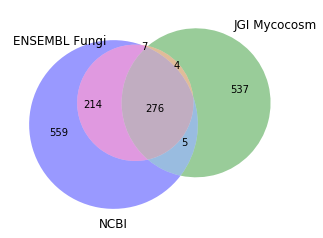

In [16]:
#Abc, aBc, ABc, abC, AbC, aBC, ABC
venn3(subsets=(ensembl,jgi,ensembl_jgi,ncbi,ensembl_ncbi,jgi_ncbi,all_three), set_labels=("ENSEMBL Fungi","JGI Mycocosm","NCBI"))
plt.show()